In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

import numpy as np

# generate training and testing data

In [3]:
def gen_data(x):
    y = x * np.sin(x*10) + 1 
    y += np.random.uniform(0, 0.1, size=(len(y)))
    return y

In [4]:
# generate some fake data
x = np.linspace(-1, 1, 100)
# x = x[::6]
y = gen_data(x)

x = x.reshape(-1, 1)

In [5]:
# validation data
x_val = np.arange(-1, 1, 0.001)
y_val = gen_data(x_val)

x_val = x_val.reshape(-1, 1)

In [18]:
x_remove = np.delete(x, range(25,75)).reshape(-1,1)
y_remove = np.delete(y, range(25,75))

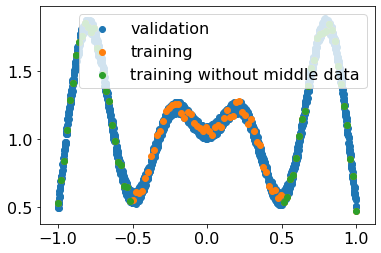

In [19]:
plt.figure()
plt.scatter(x_val, y_val, label='validation')
plt.scatter(x, y, label='training')

plt.scatter(x_remove, y_remove, label='training without middle data')

plt.legend()

# dev fit

## scale code

In [40]:
x.shape

(100, 1)

In [41]:
y.shape

(100,)

In [121]:
def make_scalers(X):
    """
    returns a list of sklearn.preprocessing.StandardScaler
    of input matrix.
    
    N, M = X.shape
    N = number of entries
    M = dimensionality
    """
    N, M = X.shape

    scalers = []
    
    # make a scaler for each dimension
    for i in range(M):
        scalers.append(StandardScaler())
        scalers[i].fit(X[:,i].reshape(-1,1))
        
    return scalers

In [122]:
def apply_scaler(X, scalers):
    """
    applies the scalers to X
    N, M = X.shape
    N = number of entries
    M = dimensionality
    """
    N, M = X.shape
    
    X_scaled = np.zeros(shape=(N,M))
    
    for i in range(M):
        X_scaled[:,i] = scalers[i].transform(X[:,i].reshape(-1,1)).reshape(1, -1)
        
    return X_scaled

In [123]:
def apply_inverse_scaler(X_scaled, scalers):
    """
    applies the inverse scalers to X_scaled
    N, M = X.shape
    N = number of entries
    M = dimensionality
    """
    N, M = X_scaled.shape
    
    X = np.zeros(shape=(N,M))
    
    for i in range(M):
        X[:,i] = scalers[i].inverse_transform(X_scaled[:,i].reshape(-1,1)).reshape(1, -1)
        
    return X

In [124]:
X_scalers = make_scalers(x)

In [125]:
X_scaled = apply_scaler(X, X_scalers)

In [126]:
X = apply_inverse_scaler(X_scaled, X_scalers)

In [127]:
np.testing.assert_almost_equal(X, x)

In [157]:
np.testing.assert_almost_equal(np.mean(X_scaled), 0)

In [158]:
np.testing.assert_almost_equal(np.std(X_scaled), 1)

In [153]:
y_scalers = make_scalers(y.reshape(-1, 1))

y_scaled = apply_scaler(y.reshape(-1,1), y_scalers)

y_inv_scaled = apply_inverse_scaler(y_scaled, y_scalers)


In [156]:
np.testing.assert_almost_equal(y_inv_scaled, y.reshape(-1,1))

In [150]:
np.testing.assert_almost_equal(np.mean(y_scaled), 0)

In [151]:
np.testing.assert_almost_equal(np.std(y_scaled), 1)

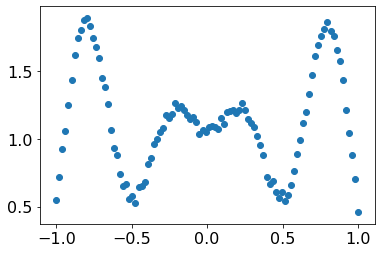

In [142]:
plt.figure()
plt.scatter(x, y)

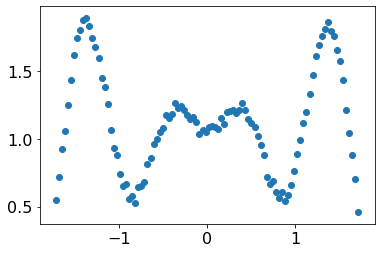

In [143]:
plt.figure()
plt.scatter(X_scaled, y)

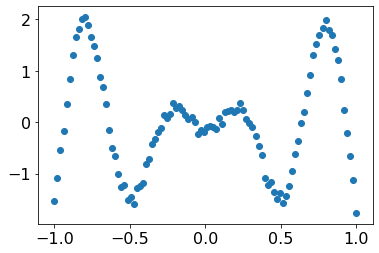

In [144]:
plt.figure()
plt.scatter(x, y_scaled)

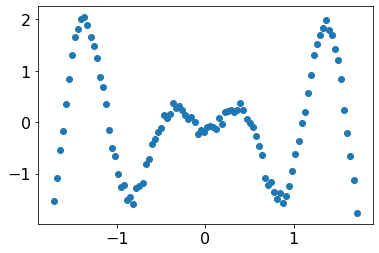

In [145]:
plt.figure()
plt.scatter(X_scaled, y_scaled)

In [146]:
np.mean(y)

1.1220042033860649

In [147]:
np.mean(y_scaled)

0.0

In [148]:
np.std(y)

0.37355006415435926

In [149]:
np.std(y_scaled)

1.0

## nn code

In [210]:
import numpy as np

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LeakyReLU, ReLU, ELU
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler

class RegressionANN(object):
    """
    Use tensorflow.keras to build an artifical neural network for regression
    """
    def __init__(self):
        pass

    def fit(self, X, y, input_dim, noutput, epochs, validation_data=None, outname='best', scaleX=True, scaleY=True):
        """
        input_dim: {int}. dimension of input layer
        noutput: {int}. number of outputs in final layer
        validation_data: (X_test, y_test)
        """
        self.scaleX = scaleX
        self.scaleY = scaleY
        if self.scaleX:
            X = X.copy()
            self.X_scalers = make_scalers(X)
            X = apply_scaler(X, self.X_scalers)
        if self.scaleY:
            y = y.copy()
            self.Y_scalers = make_scalers(y)
            y = apply_scaler(y, self.Y_scalers)

        # Initialising the ANN
        self.model = Sequential()

        # Adding the input layer and the first hidden layer
        self.model.add(Dense(512, activation = 'relu', input_dim = 1))

        # Adding the second hidden layer
        self.model.add(Dense(units = 512, activation = 'relu'))

        # Adding the third hidden layer
        self.model.add(Dense(units = 512, activation = 'relu'))

        # model.add(Dropout(0.5))

        # Adding the output layer

        self.model.add(Dense(units = noutput))

        #model.add(Dense(1))
        # Compiling the ANN
        self.model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])

        # Fitting the ANN to the Training set
        history = self.model.fit(
            X,
            y,
            epochs=epochs,
            verbose=0,
            validation_data=validation_data,
            callbacks=[ModelCheckpoint(f'{outname}.h5', save_best_only=True, monitor='loss')]
        )

        return history

    def load_model(self, file):
        self.model = load_model(file)

    def predict(self, X):
        if self.scaleX:
            X = apply_scaler(X, self.X_scalers)

        y = self.model.predict(X)

        if self.scaleY:
            y = apply_inverse_scaler(y, self.Y_scalers)

        return y

In [211]:
y.shape

(100,)

In [217]:
def fit_with_nn(x, y):
    fit = RegressionANN()
    fit.fit(x, y, input_dim=1, noutput=1, epochs=500, validation_data=None, outname='best', scaleX=True, scaleY=True)
    return fit

In [218]:
fit = fit_with_nn(x, y.reshape(-1,1))

only working for 1D ATM


In [219]:
yhat = fit.predict(x)

prediction: only working for 1D ATM


In [220]:
x.shape

(100, 1)

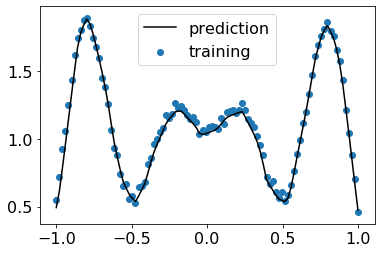

In [221]:
plt.figure()
plt.scatter(x, y, label='training')

plt.plot(x, yhat, label='prediction', c='k')

plt.legend()

# import scrinet and perform fits

In [8]:
from scrinet import fits

In [9]:
dir(fits.nn)

['Activation',
 'Dense',
 'Dropout',
 'ELU',
 'LeakyReLU',
 'ModelCheckpoint',
 'ReLU',
 'RegressionANN',
 'Sequential',
 'StandardScaler',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'load_model',
 'np',
 'scale',
 'tensorflow']

In [56]:
def fit_with_nn(x, y):
    fit = fits.nn.RegressionANN()
    fit.fit(x, y, input_dim=1, noutput=1, epochs=1000, validation_data=None, outname='best', scaleX=True, scaleY=True)
    return fit

In [57]:
fit = fit_with_nn(x, y.reshape(-1,1))

In [58]:
fit_remove = fit_with_nn(x_remove, y_remove.reshape(-1,1))

In [59]:
yhat = fit.predict(x)

In [60]:
yhat_remove = fit_remove.predict(x)

In [61]:
x.shape

(100, 1)

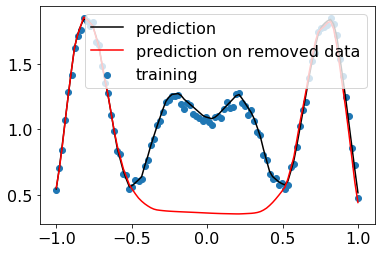

In [62]:
plt.figure()
plt.scatter(x, y, label='training')

plt.plot(x, yhat, label='prediction', c='k')

plt.plot(x, yhat_remove, label='prediction on removed data', c='r')


plt.legend()

In [63]:
yhat_pred = fit.predict(x_val)
yhat_remove_pred = fit_remove.predict(x_val)

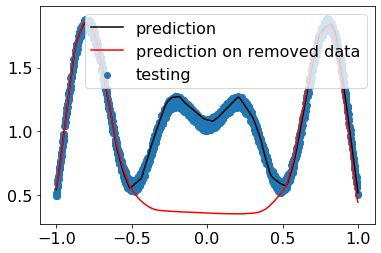

In [64]:
plt.figure()
plt.scatter(x_val, y_val, label='testing')

plt.plot(x_val, yhat_pred, label='prediction', c='k')

plt.plot(x_val, yhat_remove_pred, label='prediction on removed data', c='r')

plt.legend()

In [65]:
x.shape

(100, 1)

In [66]:
y.shape

(100,)

In [67]:
yhat.shape

(100, 1)

Text(0.5, 1.0, 'training set difference')

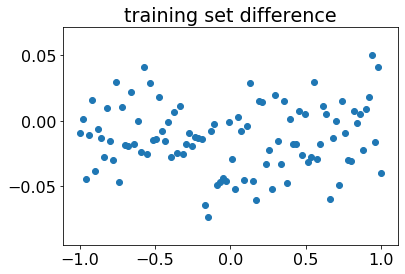

In [68]:
plt.figure()
plt.scatter(x, y - yhat.reshape(-1))
plt.title("training set difference")

Text(0.5, 1.0, 'validation set difference')

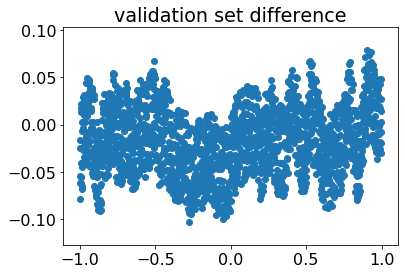

In [69]:
plt.figure()
plt.scatter(x_val, y_val - yhat_pred.reshape(-1))
plt.title("validation set difference")